# Setup

In [1]:
# Import the package
import sys
import os

package_path = "../funROI"
sys.path.append(os.path.abspath(package_path))

import funROI
from funROI import first_level, analysis, ParcelsConfig, FROIConfig
from nilearn.plotting import plot_stat_map, plot_glass_brain

# import warnings
# warnings.filterwarnings("ignore")

In [2]:
# Configure the paths for the dataset and analysis
funROI.set_bids_data_folder("./data/bids")
funROI.set_bids_deriv_folder("./data/bids/derivatives")
funROI.set_bids_preprocessed_folder("./data/bids/derivatives/fmriprep")
funROI.set_analysis_output_folder("./funroi_analysis_demo")

# First Level Modeling

## Nilearn first level modeling from fMRIPrep derivatives

In [7]:
from funROI.first_level.nilearn import run_first_level

run_first_level(
    subjects=['199'],
    tasks=['langlocSN'],
    space='MNI152NLin6Asym',
    data_filter=[('res', '2')],
    other_contrasts=['S-N'],
    confound_labels = ["trans_x", "trans_y", "trans_z", "rot_x", "rot_y", "rot_z"]
)

Saving design matrix for subject 199
Running GLM for subject 199
Saving model files for subject 199
Creating main contrasts for subject 199
Creating additional contrasts for subject 199


## SPM first level results to BIDS

For the demo here, we are using the precalculated SPM first level results.
The below codes migrate SPM first level results to the BIDS directory, to be
used for the following analysis.

In [9]:
!rm -r ./data/bids/derivatives/first_level_*

In [10]:
# Find and migrate all the SPM first level results for subjects who have done
# the following tasks
from funROI.first_level.spm import migrate_first_level_from_spm
import glob

spm_data_dir = "./data/spm_first_level_results"
for task, task_suffix in [
    ("SWNloc", "SWNlocIPS168_3runs"),
    ("EventsOrig", "EventsOrig_instrsep_2runs"),
]:
    spm_folders = glob.glob(os.path.join(spm_data_dir, f"*_{task_suffix}"))
    for spm_folder in spm_folders:
        subject_id = os.path.basename(spm_folder).split("_")[0]
        migrate_first_level_from_spm(spm_folder, subject_id, task)

In [4]:
# This the set of subjects we are using for the demo
subjects=["040", "057", "059", "056", "067", "068", "019", "070", "087", 
          "078", "089", "076"]

# Parcels Generation

## Language Parcels

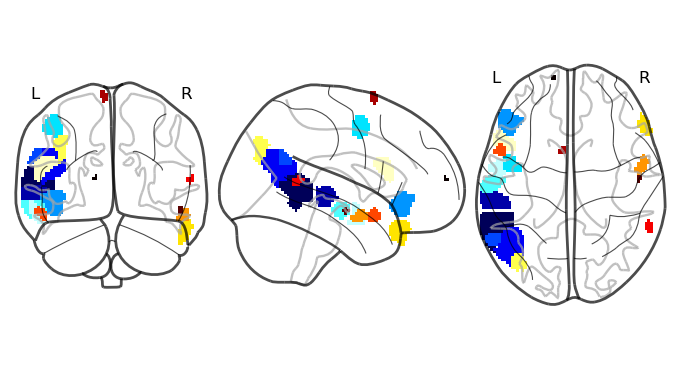

In [5]:
parcels_generator = analysis.ParcelsGenerator(
    parcels_name="Language_S-N",
    smoothing_kernel_size=6,
    overlap_thr_vox=0.1,
    use_spm_smooth=True,
)
parcels_generator.add_subjects(
    subjects=subjects,
    task="SWNloc",
    contrasts=["S-N"],
    p_threshold_type="none",
    p_threshold_value=0.001,
)
parcels = parcels_generator.run(return_results=True)
plot_glass_brain(parcels, plot_abs=False)

/Users/ruimingao/Documents/funROI_all/funROI/funROI/analysis/parcels_gen.py:408: RuntimeWarning: divide by zero encountered in divide
  return len(data) / np.sum(1 / data)


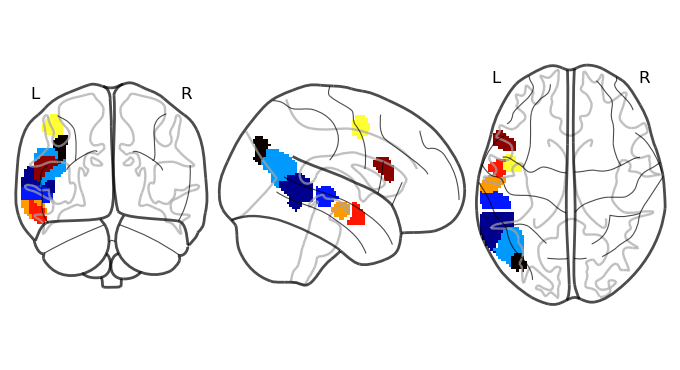

In [6]:
# Parcels thresholding could be also done using the voxel size and the parcels'
# overlap with individual activation maps
filtered_img = parcels_generator.filter(
    min_voxel_size=100, overlap_thr_roi=0.5, return_results=True
)
plot_glass_brain(filtered_img, plot_abs=False)

## Events Parcels

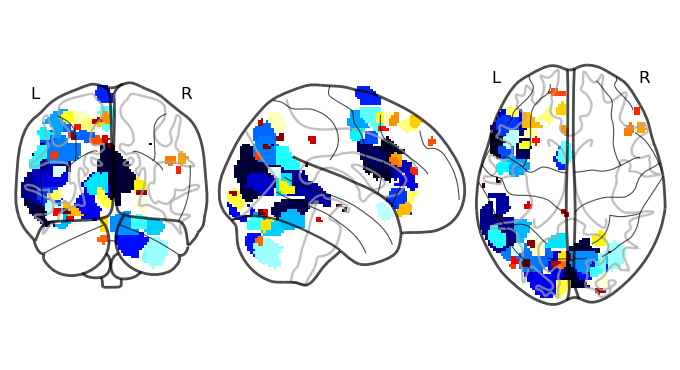

In [7]:
# Events parcels defined by sentence Sem-Perc contrast
parcels_generator = analysis.ParcelsGenerator(
    parcels_name="Events_SentSem-Perc",
    smoothing_kernel_size=6,
    overlap_thr_vox=0.1,
    use_spm_smooth=True,
)
parcels_generator.add_subjects(
    subjects=subjects,
    task="EventsOrig",
    contrasts=["Sem_sentminusPerc_sent"],
    p_threshold_type="none",
    p_threshold_value=0.05,
)
parcels = parcels_generator.run(return_results=True)
plot_glass_brain(parcels, plot_abs=False)

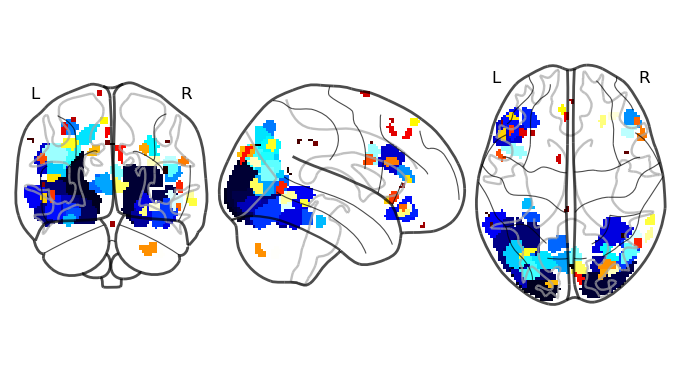

In [8]:
# Events parcels defined by photo Sem-Perc contrast
parcels_generator = analysis.ParcelsGenerator(
    parcels_name="Events_PhotoSem-Perc",
    smoothing_kernel_size=6,
    overlap_thr_vox=0.1,
    use_spm_smooth=True,
)
parcels_generator.add_subjects(
    subjects=subjects,
    task="EventsOrig",
    contrasts=["Sem_photominusPerc_photo"],
    p_threshold_type="none",
    p_threshold_value=0.05,
)
parcels = parcels_generator.run(return_results=True)
plot_glass_brain(parcels, plot_abs=False)

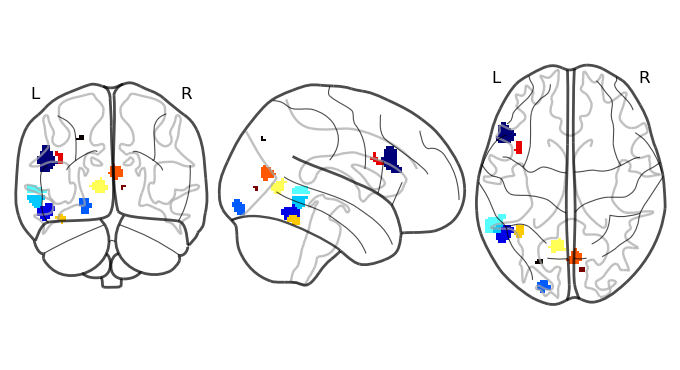

In [9]:
# Events parcels defined by both Sem-Perc contrast, conjuncted by 'and'
parcels_generator = analysis.ParcelsGenerator(
    parcels_name="Events_SentPhotoSem-Perc",
    smoothing_kernel_size=6,
    overlap_thr_vox=0.1,
    use_spm_smooth=True,
)
parcels_generator.add_subjects(
    subjects=subjects,
    task="EventsOrig",
    contrasts=["Sem_photominusPerc_photo", "Sem_sentminusPerc_sent"],
    p_threshold_type="none",
    p_threshold_value=0.05,
    conjunction_type="and",
)
parcels = parcels_generator.run(return_results=True)
plot_glass_brain(parcels, plot_abs=False)

# fROI Definition

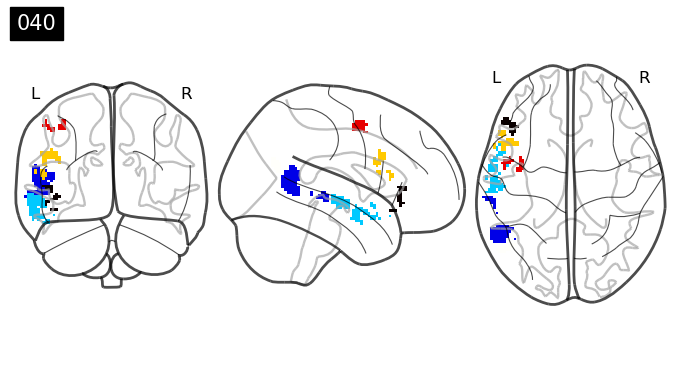

In [10]:
froi_config = FROIConfig(
    task="SWNloc",
    contrasts=["S-N"],
    threshold_type="percent",
    threshold_value=0.1,
    parcels='./data/spm_first_level_results/Language.nii'
)
froi_generator = analysis.FROIGenerator(subjects, froi_config)
froi_imgs = froi_generator.run(return_results=True)
subject_label, froi_img = froi_imgs[0]
plot_glass_brain(froi_img, plot_abs=False, title=subject_label)

# fROI Effect Estimation

In [11]:
froi = funROI.FROIConfig(
    task="SWNloc",
    contrasts=["S-N"],
    threshold_type="percent",
    threshold_value=0.1,
    parcels="./data/spm_first_level_results/Language.nii",
)
effect_estimator = analysis.EffectEstimator(subjects=subjects, froi=froi)
df_summary, df_detail = effect_estimator.run(
    task="SWNloc", effects=["S", "W", "N"], return_results=True)
df_summary

,froi,size,subject,effect
0,1,1.234898,040,S
1,2,0.302637,040,S
2,3,-0.031003,040,S
3,4,1.619401,040,S
4,5,0.389397,040,S
...,...,...,...,...
1,2,-0.465259,076,N
2,3,-0.904996,076,N
3,4,0.668672,076,N
4,5,0.800103,076,N


In [12]:
parcels_config = ParcelsConfig(
    parcels_path="./data/spm_first_level_results/Language.nii",
    labels_path="./data/spm_first_level_results/Language.txt",
)
froi = funROI.FROIConfig(
    task="SWNloc",
    contrasts=["S-N"],
    threshold_type="percent",
    threshold_value=0.1,
    parcels=parcels_config,
)
effect_estimator = analysis.EffectEstimator(subjects=subjects, froi=froi)
df_summary, df_detail = effect_estimator.run(
    task="SWNloc", effects=["S", "W", "N"], return_results=True)
df_summary

,froi,size,subject,effect
0,LIFG_orb,1.234898,040,S
1,LIFG,0.302637,040,S
2,LMFG,-0.031003,040,S
3,LAntTemp,1.619401,040,S
4,LPostTemp,0.389397,040,S
...,...,...,...,...
1,LIFG,-0.465259,076,N
2,LMFG,-0.904996,076,N
3,LAntTemp,0.668672,076,N
4,LPostTemp,0.800103,076,N


# Spatial Correlation Estimation

In [13]:
# Use parcels for spatial correlation analysis
spcorr_estimator = analysis.SpatialCorrelationEstimator(
    subjects=subjects,
    froi=f"./data/spm_first_level_results/Language.nii",
)
df_summary, df_detail = spcorr_estimator.run(
    'SWNloc', 'S', 'EventsOrig', 'Sem_sentminusPerc_sent',
    return_results=True
)
df_summary

,parcels,fisher_z,subject
0,1,0.482524,040
1,2,0.702331,040
2,3,0.289178,040
3,4,1.034799,040
4,5,0.984973,040
...,...,...,...
1,2,-0.498807,076
2,3,0.112594,076
3,4,0.237142,076
4,5,0.442788,076


In [14]:
# Use fROIs for spatial correlation analysis
parcels_config = ParcelsConfig(
    parcels_path="./data/spm_first_level_results/Language.nii",
    labels_path="./data/spm_first_level_results/Language.txt",
)
froi = funROI.FROIConfig(
    task="SWNloc",
    contrasts=["S-N"],
    threshold_type="percent",
    threshold_value=0.1,
    parcels=parcels_config,
)
spcorr_estimator = analysis.SpatialCorrelationEstimator(
    subjects=subjects,
    froi=froi
)
df_summary, df_detail = spcorr_estimator.run(
    'SWNloc', 'S', 'EventsOrig', 'Sem_sentminusPerc_sent',
    return_results=True
)
df_summary

,froi,fisher_z,subject
0,LIFG_orb,0.717063,040
1,LIFG,0.416236,040
2,LMFG,-0.029975,040
3,LAntTemp,0.941210,040
4,LPostTemp,0.560495,040
...,...,...,...
1,LIFG,-0.057839,076
2,LMFG,-0.196548,076
3,LAntTemp,0.335842,076
4,LPostTemp,0.679135,076


# Overlap Estimation

In [15]:
# Examine overlap between parcels
overlap_estimator = analysis.OverlapEstimator()
df_summary, df_detail  = overlap_estimator.run(
    froi1="./data/spm_first_level_results/Events.nii",
    froi2="./data/spm_first_level_results/Language.nii",
    return_results=True
)
df_summary

,parcel1,parcel2,overlap
0,1,1,0.000000
1,1,2,0.000000
2,1,3,0.000000
3,1,4,0.834455
4,1,5,0.006494
...,...,...,...
61,11,2,0.000000
62,11,3,0.000000
63,11,4,0.000000
64,11,5,0.000000


In [16]:
# Examine overlap between fROIs
froi1 = funROI.FROIConfig(
    task="EventsOrig",
    contrasts=["Sem_photominusPerc_photo"],
    threshold_type="percent",
    threshold_value=0.1,
    parcels="./data/spm_first_level_results/Events.nii",
)
froi2 = funROI.FROIConfig(
    task="EventsOrig",
    contrasts=["Sem_sentminusPerc_sent"],
    threshold_type="percent",
    threshold_value=0.1,
    parcels="./data/spm_first_level_results/Events.nii",
)
overlap_estimator = analysis.OverlapEstimator(subjects=subjects)
df_summary, df_detail = overlap_estimator.run(
    froi1=froi1, froi2=froi2, return_results=True
)
df_summary

,froi1,froi2,overlap,subject
0,1,1,0.179775,040
1,1,2,0.000000,040
2,1,3,0.000000,040
3,1,4,0.000000,040
4,1,5,0.000000,040
...,...,...,...,...
116,11,7,0.000000,076
117,11,8,0.000000,076
118,11,9,0.000000,076
119,11,10,0.000000,076


In [17]:
# Examine overlap between parcel and fROI
overlap_estimator = analysis.OverlapEstimator(subjects=subjects)
df_summary, df_detail = overlap_estimator.run(
    froi1="./data/spm_first_level_results/Language.nii",
    froi2=froi2, return_results=True
)
df_summary

,parcel1,froi2,overlap,subject
0,1,1,0.000000,040
1,1,2,0.000000,040
2,1,3,0.232044,040
3,1,4,0.864000,040
4,1,5,0.000000,040
...,...,...,...,...
61,6,7,0.000000,076
62,6,8,0.000000,076
63,6,9,0.000000,076
64,6,10,0.000000,076


All sample output data are stored under `funroi_analysis_demo/`.